#**Submission 2**

##Ardio Pratama Putra

In [18]:
import pandas as pd
dt = pd.read_csv('testset.csv')
dt.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [19]:
dt.isnull().sum()

datetime_utc         0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [20]:
dt['datetime_utc'] = pd.to_datetime(dt['datetime_utc'])
dt[' _hum'].fillna(dt[' _hum'].mean(), inplace=True)
dt = dt[['datetime_utc',' _hum']]
dt.head()

,datetime_utc,_hum
0,1996-11-01 11:00:00,27.0
1,1996-11-01 12:00:00,32.0
2,1996-11-01 13:00:00,44.0
3,1996-11-01 14:00:00,41.0
4,1996-11-01 16:00:00,47.0


In [21]:
dt['datetime_utc'] = dt['datetime_utc'].dt.date
dt = dt.rename(columns={'datetime_utc':'date',' _hum':'hum'})
dt.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,hum
0,1996-11-01,27.0
1,1996-11-01,32.0
2,1996-11-01,44.0
3,1996-11-01,41.0
4,1996-11-01,47.0


In [22]:
dt.shape

(100990, 2)

In [23]:
date = dt['date'].values
hum = dt['hum'].values

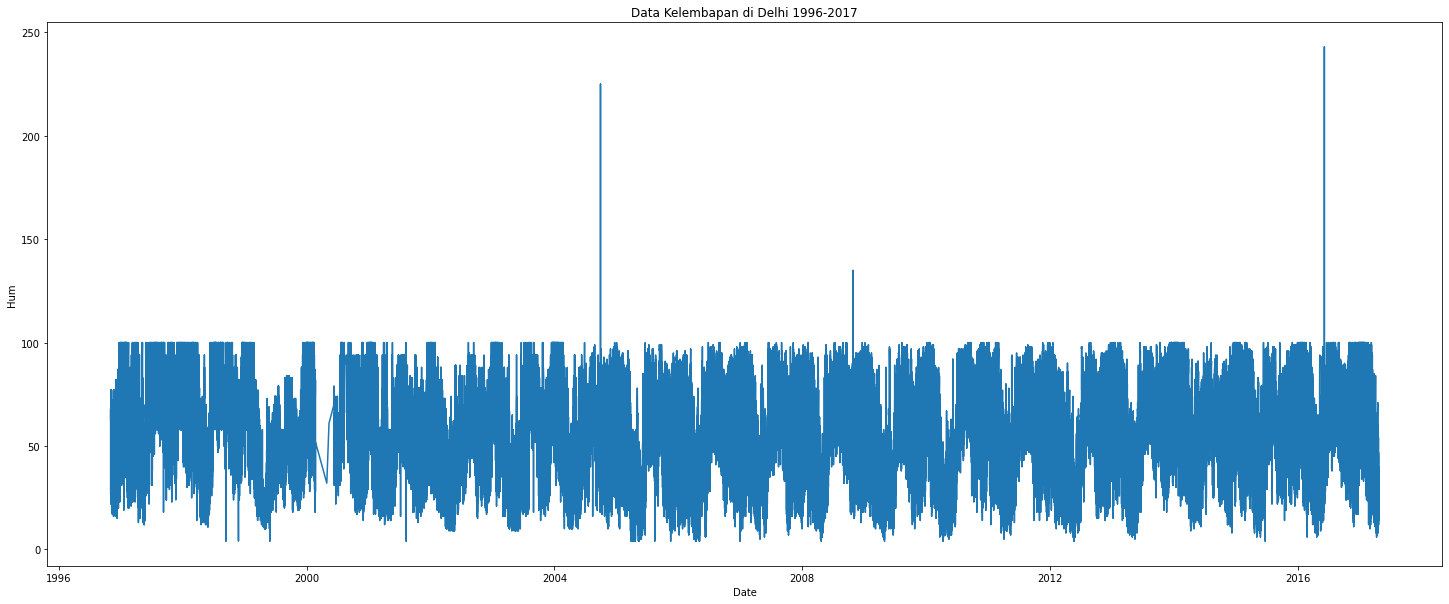

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.plot(date, hum)
plt.title('Data Kelembapan di Delhi 1996-2017')
plt.xlabel('Date')
plt.ylabel('Hum')
plt.show()

In [25]:
import tensorflow as tf

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series,axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(hum, date, test_size = 0.2, shuffle = False, random_state=0)

In [28]:
from keras.layers import Dense, LSTM

train_set = windowed_dataset(x_train, 60, 100, 5000)
test_set = windowed_dataset(x_test, 60, 100, 5000)

In [29]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(strides=1,
                                                           kernel_size=5, 
                                                           filters=32, 
                                                           padding="causal",
                                                           input_shape=[None, 1],
                                                           activation="relu"),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [30]:
max = dt['hum'].max()
min = dt['hum'].min()
data_scale = (max - min)*0.1
print('MAE data scale below 10% is', data_scale)

MAE data scale below 10% is 23.900000000000002


In [31]:
class MAECallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<data_scale):
      self.model.stop_training = True
      print("\nBelow 10% Data Scale")
callbacks = MAECallback()

In [32]:
hist = model.fit(train_set, validation_data=test_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
808/808 [==============================] - 146s 171ms/step - loss: 93.0347 - mae: 93.5347 - val_loss: 58.4721 - val_mae: 58.9720
Epoch 2/100
808/808 [==============================] - 135s 166ms/step - loss: 44.0486 - mae: 44.5477 - val_loss: 36.5362 - val_mae: 37.0339
Epoch 3/100
808/808 [==============================] - 128s 158ms/step - loss: 28.9347 - mae: 29.4313 - val_loss: 26.8296 - val_mae: 27.3256
Epoch 4/100
808/808 [==============================] - ETA: 0s - loss: 22.5503 - mae: 23.0458
Below 10% Data Scale
808/808 [==============================] - 128s 157ms/step - loss: 22.5503 - mae: 23.0458 - val_loss: 22.6662 - val_mae: 23.1618


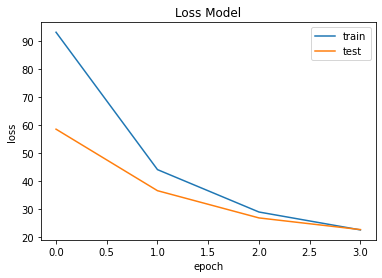

In [33]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

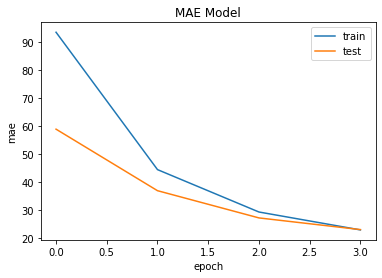

In [34]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()